In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import os

In [3]:
class FFTLowFreqSelector(torch.nn.Module):
    """
    MNIST/FashionMNIST 等の2D画像を FFT し、fftshift 後の中心(低周波)から
    半径の近い順に out_dim 個の周波数成分 (振幅) を抜き出して特徴ベクトルにするクラス。

    - 入力: x (B, C, H, W)  [float]
    - 出力: (B, out_dim)    [float]
    """
    def __init__(self, out_dim: int = 25, log_magnitude: bool = True, eps: float = 1e-12):
        super().__init__()
        self.out_dim = int(out_dim)
        self.log_magnitude = bool(log_magnitude)
        self.eps = float(eps)
        # 画像サイズごとに選択インデックスをキャッシュ
        self._cached_idx = {}   # key=(H,W) -> dict{"flat": LongTensor(K,), "ij": LongTensor(K,2)}

    @torch.no_grad()
    def _prepare_indices(self, H: int, W: int, device: torch.device):
        """中心からの半径昇順（同半径は角度昇順）で K=out_dim 個の画素インデックスを決めてキャッシュ。"""
        if (H, W) in self._cached_idx:
            return
        # 座標グリッド（行=Y=i, 列=X=j）
        ys = torch.arange(H, device=device).float()
        xs = torch.arange(W, device=device).float()
        yy, xx = torch.meshgrid(ys, xs, indexing="ij")

        cy = (H - 1) / 2.0
        cx = (W - 1) / 2.0
        dy = yy - cy
        dx = xx - cx
        r2 = dy * dy + dx * dx
        ang = torch.atan2(dy, dx)  # -pi..pi

        # (H*W,) にして複合キーでソート
        r2_f = r2.flatten()
        ang_f = ang.flatten()
        # 距離→角度のタプルで安定ソートするため、まず距離で昇順、距離同値は角度で昇順
        # 距離を主キー、角度を副キーにするために、距離に極小の角度正規化を足す手もあるが、
        # ここでは2段階ソートを使う。
        # 1) 角度でソートインデックス
        _, idx_ang = torch.sort(ang_f)
        # 2) 上の結果を使って距離で安定ソート
        r2_sorted, idx_r2 = torch.sort(r2_f[idx_ang], stable=True)
        idx_all = idx_ang[idx_r2]

        K = min(self.out_dim, H * W)
        idx_k = idx_all[:K]  # (K,)

        # 2次元インデックス (i,j)
        iy = (idx_k // W).long()
        ix = (idx_k %  W).long()
        ij = torch.stack([iy, ix], dim=1).long()

        self._cached_idx[(H, W)] = {"flat": idx_k.long(), "ij": ij.long()}

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, C, H, W) または (B, H, W)/(B, H*W)
        return: (B, out_dim)
        """
        B, C, H, W = x.shape
        if self.out_dim > H * W:
            raise ValueError(f"out_dim={self.out_dim} exceeds image size H*W={H*W}")

        self._prepare_indices(H, W, x.device)
        idx_flat = self._cached_idx[(H, W)]["flat"]  # (K,)
        # FFT -> shift -> magnitude
        X = torch.fft.fft2(x, dim=(-2, -1))
        X = torch.fft.fftshift(X, dim=(-2, -1))
        mag = X.abs()
        if self.log_magnitude:
            mag = torch.log1p(mag + self.eps)

        # (B, C, H*W) にして、同一 idx_flat を切り出し (B, C, K) -> チャンネル平均 -> (B, K)
        mag_flat = mag.reshape(B, C, H * W)
        feats_bcK = torch.index_select(mag_flat, dim=2, index=idx_flat)  # (B, C, K)
        feats = feats_bcK.mean(dim=1)  # (B, K)
        return feats

    @torch.no_grad()
    def get_selected_coords(self, H: int, W: int, device=None) -> torch.Tensor:
        """選ばれる (i,j) インデックス（K,2）を返す。"""
        dev = device if device is not None else torch.device("cpu")
        self._prepare_indices(H, W, dev)
        return self._cached_idx[(H, W)]["ij"].clone()

    @torch.no_grad()
    def reconstruct_from_lowfreq(self, x: torch.Tensor, sample_index: int = 0) -> torch.Tensor:
        """
        選択した低周波成分のみを使用して逆フーリエ変換で画像を復元する。
        
        Args:
            x: 入力画像テンソル (B, C, H, W)
            sample_index: 復元するサンプルのインデックス
            
        Returns:
            復元された画像 (H, W)
        """
        B, C, H, W = x.shape
        if not (0 <= sample_index < B):
            raise IndexError(f"sample_index {sample_index} out of range (0..{B-1})")
            
        self._prepare_indices(H, W, x.device)
        idx_flat = self._cached_idx[(H, W)]["flat"]  # (K,)
        ij = self._cached_idx[(H, W)]["ij"]  # (K, 2)
        
        # 1サンプルのFFT
        x_single = x[sample_index:sample_index+1]  # (1, C, H, W)
        X = torch.fft.fft2(x_single, dim=(-2, -1))
        X_shifted = torch.fft.fftshift(X, dim=(-2, -1))
        
        # 低周波成分のみを保持するマスク作成
        X_lowfreq = torch.zeros_like(X_shifted)
        
        # 選択された低周波成分のみをコピー
        for c in range(C):
            for k in range(len(idx_flat)):
                i, j = ij[k]
                X_lowfreq[0, c, i, j] = X_shifted[0, c, i, j]
        
        # 逆フーリエ変換
        X_lowfreq_ishifted = torch.fft.ifftshift(X_lowfreq, dim=(-2, -1))
        reconstructed = torch.fft.ifft2(X_lowfreq_ishifted, dim=(-2, -1)).real
        
        # チャンネル平均して (H, W) にする
        reconstructed = reconstructed.mean(dim=1).squeeze(0)  # (H, W)
        
        return reconstructed

    @torch.no_grad()
    def plot_example(self, x: torch.Tensor, sample_index: int = 0, annotate: bool = True, savepath: str = None):
        """
        バッチ x から sample_index 番目を可視化。
        ・元画像
        ・FFT(shift後)の log 振幅スペクトル
        ・どの out_dim 成分を抜いたか（スペクトル上にマーカー）
        ・低周波成分からの復元画像
        """
        B, C, H, W = x.shape
        if not (0 <= sample_index < B):
            raise IndexError(f"sample_index {sample_index} out of range (0..{B-1})")
        
        # 1枚取り出し（表示は1ch目）
        img_tensor = x[sample_index, 0].detach().cpu().float()  # (H, W)
        # 正規化を戻す: Normalize((0.5,), (0.5,)) の逆変換
        img = img_tensor * 0.5 + 0.5  # [-1,1] -> [0,1] に戻す
        img = torch.clamp(img, 0, 1)  # 範囲をクリップ
        img = img.numpy()

        # FFT スペクトル（log1p 振幅）
        X = torch.fft.fft2(x[sample_index:sample_index+1], dim=(-2, -1))
        X = torch.fft.fftshift(X, dim=(-2, -1))
        mag = X.abs().mean(dim=1)  # (1, H, W) チャンネル平均
        spec = torch.log1p(mag + self.eps)[0].detach().cpu().float().numpy()

        # 低周波成分からの復元画像
        reconstructed = self.reconstruct_from_lowfreq(x, sample_index)
        # 正規化を戻す
        reconstructed_denorm = reconstructed * 0.5 + 0.5
        reconstructed_denorm = torch.clamp(reconstructed_denorm, 0, 1)
        reconstructed_img = reconstructed_denorm.detach().cpu().numpy()

        # マーカー座標
        ij = self.get_selected_coords(H, W, device=x.device).cpu().numpy()  # (K,2)
        iy, ix = ij[:, 0], ij[:, 1]

        # 図を描く（4つのサブプロット）
        fig = plt.figure(figsize=(16, 4))
        ax1 = fig.add_subplot(1, 4, 1)
        ax2 = fig.add_subplot(1, 4, 2)
        ax3 = fig.add_subplot(1, 4, 3)
        ax4 = fig.add_subplot(1, 4, 4)

        ax1.imshow(img, cmap="gray", interpolation="nearest", vmin=0, vmax=1)
        ax1.set_title("Original")
        ax1.axis("off")

        ax2.imshow(spec, cmap="gray", interpolation="nearest")
        ax2.set_title("FFT |X| (log)")
        ax2.axis("off")

        ax3.imshow(spec, cmap="gray", interpolation="nearest")
        ax3.scatter(ix, iy, marker="o", s=30, c='red', alpha=0.7)
        if annotate:
            for k, (yy, xx) in enumerate(zip(iy, ix)):
                ax3.text(xx + 0.5, yy + 0.5, str(k+1), fontsize=7, color='blue')
        ax3.set_title(f"Selected {self.out_dim} low-freq bins")
        ax3.axis("off")

        ax4.imshow(reconstructed_img, cmap="gray", interpolation="nearest", vmin=0, vmax=1)
        ax4.set_title("Reconstructed from low-freq")
        ax4.axis("off")

        plt.tight_layout()
        if savepath:
            plt.savefig(savepath, bbox_inches="tight", dpi=150)
        plt.show()

In [4]:
class PMEncoder(nn.Module):
    def __init__(self,input_dim,output_dim,alpha,device='cpu'):
        super(PMEncoder,self).__init__()
        phase = torch.rand(output_dim, input_dim) * 2 * np.pi - np.pi
        modulus = torch.ones(output_dim, input_dim)/np.sqrt(input_dim)

        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False
        self.alpha = (torch.rand(input_dim) - 0.5) * (2*alpha) 
        self.alpha = self.alpha.detach().to(device) 
        self.alpha.requires_grad = False

    def forward(self, x):
        x = torch.exp(1j * self.alpha * x) 
        x = x.T  
        x = torch.matmul(self.B, x).T 
        x = torch.abs(x)**2 
        return x

In [5]:
def load_Fmnist_data():
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),  # ±10度回転
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # 適切な正規化値
        lambda x: x.view(-1)
    ])

    root = os.path.join('..','..','dataloader', 'samples', 'Fmnist_data')
    fmnist_train = datasets.FashionMNIST(root=root,download=True,train=True,transform=transform)
    fmnist_test = datasets.FashionMNIST(root=root,download=True,train=False,transform=transform)
    return(fmnist_train,fmnist_test)

def get_new_dataloader(data_train,data_test,batch_size=100):
    train_dataloader = DataLoader(data_train,batch_size,shuffle=True)
    
    test_dataloader = DataLoader(data_test,batch_size,shuffle=False)
    return train_dataloader, test_dataloader

input shape: torch.Size([100, 1, 28, 28])
features shape: torch.Size([100, 32])

FFT features for sample 97:
Shape: torch.Size([32])
Values: [3.0158648 3.4922762 6.0983033 5.5971465 1.3874239 2.346907  2.7717917
 3.3219228 5.5971465 3.4922762 3.321923  4.7070527 2.5602272 3.2787716
 3.0158646 2.82977   2.2823148 2.1964693 2.5614276 2.82977   4.7070527
 2.771792  3.2787714 3.2549963 1.4731878 2.330824  2.9533842 2.657624
 1.3874236 2.3469071 2.657624  2.9708178]

=== Excel用出力（タブ区切り）===
Feature	Value
1	3.015865
2	3.492276
3	6.098303
4	5.597147
5	1.387424
6	2.346907
7	2.771792
8	3.321923
9	5.597147
10	3.492276
11	3.321923
12	4.707053
13	2.560227
14	3.278772
15	3.015865
16	2.829770
17	2.282315
18	2.196469
19	2.561428
20	2.829770
21	4.707053
22	2.771792
23	3.278771
24	3.254996
25	1.473188
26	2.330824
27	2.953384
28	2.657624
29	1.387424
30	2.346907
31	2.657624
32	2.970818


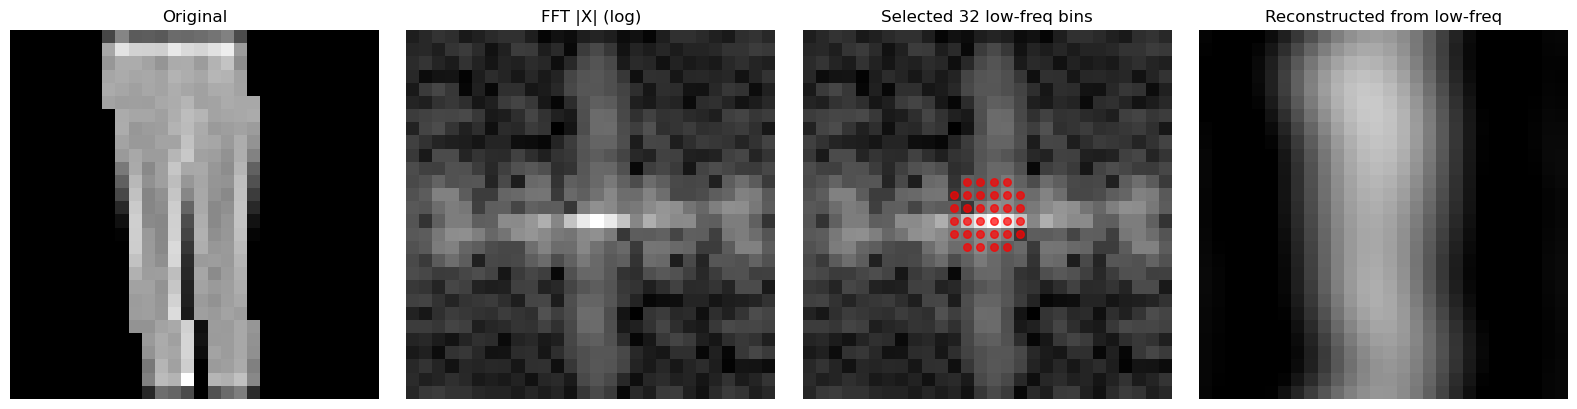

In [6]:

# ===== デモ（ランダム画像で動作チェック） =====
if __name__ == "__main__":
    torch.manual_seed(0)
    B, C, H, W = 100, 1, 28, 28  # MNIST想定
    data_train, data_test = load_Fmnist_data()
    train_dataloader, test_dataloader = get_new_dataloader(data_train, data_test, batch_size=B)
    batch_data = next(iter(test_dataloader))
    x, labels = batch_data  # データとラベルを分離
    x = x.view(B, C, H, W)  # (B, 1, 28, 28)
    print("input shape:", x.shape)
    extractor = FFTLowFreqSelector(out_dim=32, log_magnitude=True)
    feats = extractor(x)  # (B, 32)
    print("features shape:", feats.shape)

    sample_index = random.randint(0, B-1)  # 可視化するサンプルのインデックス
    sample_index = 97
    # sample_indexの32次元ベクトルを取得して表示
    sample_features = feats[sample_index]  # (32,)

    ln = torch.nn.LayerNorm(32)
    # sample_features = ln(sample_features.unsqueeze(0)).squeeze(0)  # squeeze(0)を追加
    print(f"\nFFT features for sample {sample_index}:")
    print(f"Shape: {sample_features.shape}")
    print(f"Values: {sample_features.detach().cpu().numpy()}")

    # より見やすい表示

# エクセル用の出力（タブ区切り）
    print(f"\n=== Excel用出力（タブ区切り）===")
    print("Feature\tValue")
    for i, val in enumerate(sample_features.detach().cpu().numpy()):
        print(f"{i+1}\t{val:.6f}")

    # 可視化も実行
    extractor.plot_example(x, sample_index=sample_index, annotate=False, savepath=None)

In [7]:
encoder = PMEncoder(input_dim=32,output_dim=17,alpha=1,device='cpu')
encoded_features = encoder(sample_features)  # (17,)
print(f"\nEncoded features shape: {encoded_features.shape}")
print(f"Encoded features values: {encoded_features.detach().cpu().numpy()}")
#より見やすい表示
print(f"\nFormatted Encoded features:")
for i, val in enumerate(encoded_features.detach().cpu().numpy()):
    print(f"Feature {i+1:2d}: {val:.6f}")


Encoded features shape: torch.Size([17])
Encoded features values: [0.98990464 1.7704616  0.63272357 2.4722886  0.7655126  1.1233537
 0.26768336 0.9216112  1.0694621  0.18140103 1.2184503  0.2385897
 0.8862802  0.24263003 1.4249713  0.34898293 0.47821867]

Formatted Encoded features:
Feature  1: 0.989905
Feature  2: 1.770462
Feature  3: 0.632724
Feature  4: 2.472289
Feature  5: 0.765513
Feature  6: 1.123354
Feature  7: 0.267683
Feature  8: 0.921611
Feature  9: 1.069462
Feature 10: 0.181401
Feature 11: 1.218450
Feature 12: 0.238590
Feature 13: 0.886280
Feature 14: 0.242630
Feature 15: 1.424971
Feature 16: 0.348983
Feature 17: 0.478219


C:\Users\Scent\AppData\Local\Temp\ipykernel_13632\3302058852.py:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3641.)
  x = x.T


In [11]:
import csv
import os
from tqdm import tqdm

def save_fmnist_fft_to_csv():
    """
    Fashion-MNISTデータをFFTLowFreqSelectorで変換し、全データをCSVに保存する関数
    """
    print("Loading Fashion-MNIST data...")
    
    # データ読み込み（シャッフルなし）
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    
    root = os.path.join('..','..','dataloader', 'samples', 'Fmnist_data')
    fmnist_train = datasets.FashionMNIST(root=root, download=True, train=True, transform=transform)
    
    # DataLoaderもシャッフルなしで作成
    train_dataloader = DataLoader(fmnist_train, batch_size=1000, shuffle=False)
    
    # FFTLowFreqSelectorの初期化
    extractor = FFTLowFreqSelector(out_dim=32, log_magnitude=True)
    
    # LayerNormを関数外で初期化（一貫したパラメータを使用）
    ln = torch.nn.LayerNorm(32)
    
    # CSVファイルの準備
    csv_filename = 'fashion_mnist_fft_features_ln0.csv'
    
    # ヘッダー作成
    header = ['index', 'label'] + [f'feature_{i+1}' for i in range(32)]
    
    print(f"Saving FFT features to {csv_filename}...")
    
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)
        
        data_index = 0
        
        # バッチごとに処理
        for batch_idx, (x_batch, labels_batch) in enumerate(tqdm(train_dataloader, desc="Processing batches")):
            # 形状を調整 (batch_size, 1, 28, 28)
            x_batch = x_batch.view(x_batch.size(0), 1, 28, 28)
            
            # FFT変換
            fft_features = extractor(x_batch)  # (batch_size, 32)
            fft_features = ln(fft_features)  # 正規化（一貫したパラメータで）
            
            # バッチ内の各サンプルをCSVに書き込み
            for i in range(x_batch.size(0)):
                features = fft_features[i].detach().cpu().numpy()
                label = labels_batch[i].item()
                
                # 1行のデータ: [index, label, feature_1, feature_2, ..., feature_32]
                row = [data_index, label] + features.tolist()
                writer.writerow(row)
                
                data_index += 1
    
    print(f"Complete! Saved {data_index} samples to {csv_filename}")
    print(f"File saved in: {os.path.abspath(csv_filename)}")

# 実行
save_fmnist_fft_to_csv()

Loading Fashion-MNIST data...
Saving FFT features to fashion_mnist_fft_features_ln0.csv...


Processing batches: 100%|██████████| 60/60 [00:12<00:00,  4.63it/s]

Complete! Saved 60000 samples to fashion_mnist_fft_features_ln0.csv
File saved in: c:\Users\Scent\Project\PhotonicEncoder\Runner\ex_run\fashion_mnist_fft_features_ln0.csv


In [ ]:
# 正規化の確認用コード
def check_normalization():
    # テストデータで正規化を確認
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    
    root = os.path.join('..','..','dataloader', 'samples', 'Fmnist_data')
    fmnist_train = datasets.FashionMNIST(root=root, download=True, train=True, transform=transform)
    test_loader = DataLoader(fmnist_train, batch_size=100, shuffle=False)
    
    extractor = FFTLowFreqSelector(out_dim=32, log_magnitude=True)
    ln = torch.nn.LayerNorm(32)
    
    # 1バッチ取得
    x_batch, _ = next(iter(test_loader))
    x_batch = x_batch.view(x_batch.size(0), 1, 28, 28)
    
    # FFT変換
    fft_features = extractor(x_batch)
    print("FFT features before LayerNorm:")
    print(f"  Mean: {fft_features.mean():.6f}")
    print(f"  Std: {fft_features.std():.6f}")
    
    # LayerNorm適用
    normalized_features = ln(fft_features)
    print("\nFFT features after LayerNorm:")
    print(f"  Mean: {normalized_features.mean():.6f}")
    print(f"  Std: {normalized_features.std():.6f}")
    
    # 各サンプルの統計（LayerNormは各サンプル内で正規化）
    sample_means = normalized_features.mean(dim=1)
    sample_stds = normalized_features.std(dim=1)
    print(f"\nPer-sample statistics:")
    print(f"  Sample means range: [{sample_means.min():.6f}, {sample_means.max():.6f}]")
    print(f"  Sample stds range: [{sample_stds.min():.6f}, {sample_stds.max():.6f}]")

# check_normalization()  # コメントアウト（必要時に実行）